Extracting Data: 100%|██████████████████████████████████████████████| 30/30 [00:05<00:00,  5.49it/s]


[40.73, 40.74, 40.74, 40.78, 40.89, 40.98, 41.09, 41.17, 41.23, 41.28, 41.26, 41.26, 41.29, 41.34, 41.44, 41.5, 41.56, 41.58, 41.56, 41.52, 41.49, 41.5, 41.58, 41.65, 41.67, 41.66, 41.59, 41.53, 41.51, 41.5, 41.49, 41.54, 41.59, 41.57, 41.52, 41.4, 41.33, 41.31, 41.28, 41.27, 41.23, 41.21, 41.16, 41.06, 40.95, 40.87, 40.82, 40.79, 40.78, 40.72, 40.65, 40.55, 40.41, 40.29, 40.21, 40.15, 40.13, 40.09, 40.02, 39.86, 39.74, 39.62, 39.5, 39.43, 39.39, 39.32, 39.25, 39.12, 38.95, 38.79, 38.68, 38.59, 38.53, 38.45, 38.33, 38.19, 38.05, 37.89, 37.75, 37.63, 37.54, 37.46, 37.36, 37.24, 37.08, 36.92, 36.77, 36.61, 36.52, 36.44, 36.33, 36.25, 36.08, 35.91, 35.76, 35.63, 35.51, 35.43, 35.34, 35.26, 35.11, 34.95, 34.76, 34.58, 34.47, 34.38, 34.3, 34.2, 34.08, 33.93, 33.81, 33.69, 33.57, 33.47, 33.43, 33.37, 33.29, 33.14, 33.01, 32.91, 32.86, 32.78, 32.71, 32.66, 32.61, 32.53, 32.43, 32.33, 32.24, 32.19, 32.18, 32.15, 32.1, 32.03, 31.96, 31.89, 31.81, 31.76, 31.77, 31.78, 31.77, 31.74, 31.7, 31.62, 

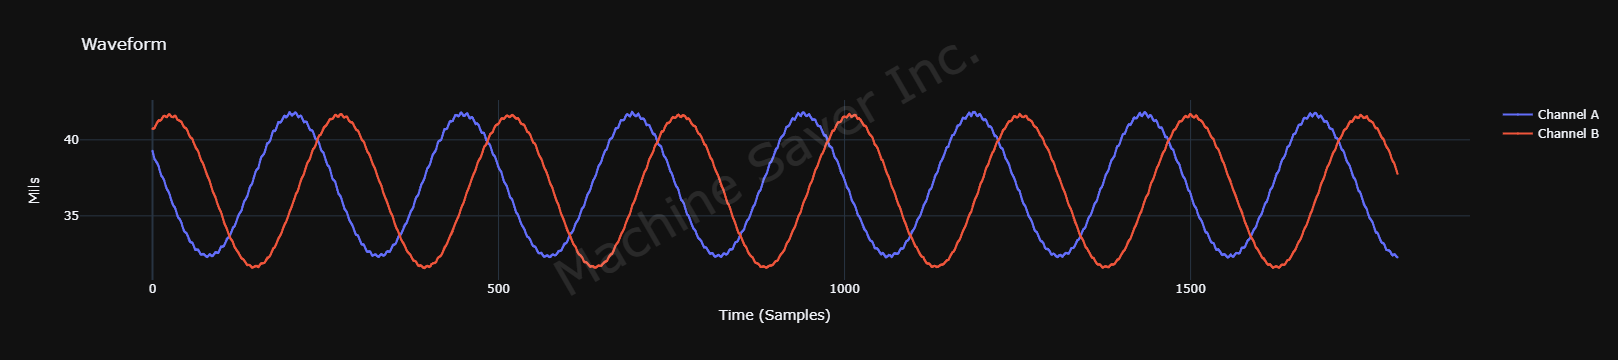

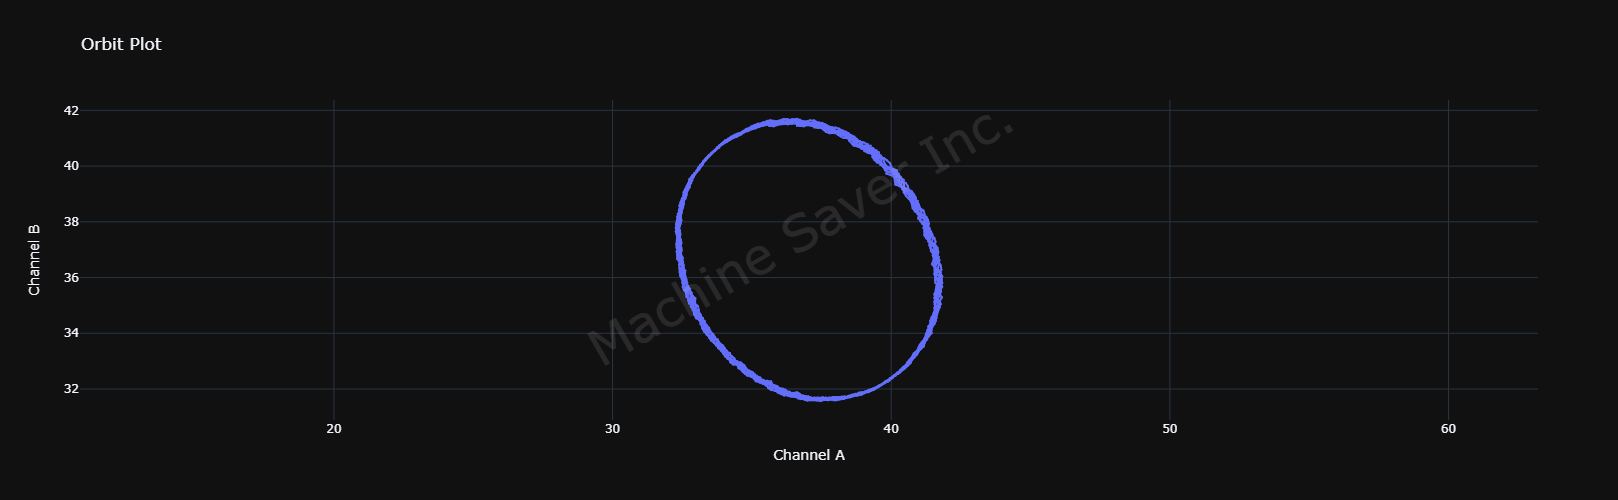

In [2]:
import minimalmodbus
import time
from datetime import datetime
import numpy as np
import struct
from tqdm import tqdm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
from typing import List, Dict, Tuple
import math

class TwinProx:
    def __init__(self, port: str, slaveaddress: int):
        self.slave = minimalmodbus.Instrument(port=port, slaveaddress=slaveaddress)
        self.configure_modbus_settings()
        self.data_array = []
        self.header = []
        self.groove_array = []
        self.waveforms = []
        self.channel_a = []
        self.channel_b = []
        self.clipsize = 3600
        self.trace_a, self.trace_b, self.trace_orbit = [], [], []

    def configure_modbus_settings(self):
        self.slave.serial.baudrate = 115200
        self.slave.serial.bytesize = 8
        self.slave.serial.parity = "N"
        self.slave.serial.stopbits = 1
        self.slave.serial.timeout = 0.10
        self.slave.close_port_after_each_call = True
        self.slave.mode = minimalmodbus.MODE_RTU
        self.slave.clear_buffers_before_each_transaction = True

    def setup_capture(self) -> int:
        tp_channel = 6
        self.clipsize = 3600
        self.slave.write_register(32, tp_channel)
        return self.slave.read_register(32)

    def trigger_capture(self) -> int:
        self.data_array, self.header, self.groove_array, self.waveforms, self.channel_a, self.channel_b = [], [], [], [], [], [] 
        self.slave.write_register(33, 1)
        return int(str(time.time())[slice(10)])

    def check_capture_engine(self) -> int:
        return self.slave.read_register(34, functioncode=3)

    def get_dataclip_size(self) -> int:
        return self.slave.read_long(36, functioncode=3)
    
    def extract_header(self) -> List[int]:
        self.header = self.data_array[:8]
        if int(self.header[4])==0:
            self.groove_array_found = False
        else:
            self.groove_array_found = True
        del self.data_array[:8]
        return self.header
    
    def extract_waves(self) -> List[int]:
        self.waveforms = self.data_array[:3600]
        del self.data_array[:3600]
        return self.waveforms
    
    def extract_grooves(self) -> List[int]:
        groove_pairs = int(self.header[4]/2)
        self.groove_array = self.data_array[:self.header[4]]
        del self.data_array[:groove_pairs]
        return self.groove_array
    
    def scale_waveforms(self) -> List[int]: 
        self.waveforms = [value / 100.0 for value in self.waveforms]
        return self.waveforms
    
    def split_channels(self) -> List[int]:
        self.channel_a = self.waveforms[:1800]
        del self.waveforms[:1800]
        print(self.waveforms)
        self.channel_b = self.waveforms[:1800]
        del self.waveforms[:1800]
        print(self.waveforms)
        return self.waveforms
    
    def decimal_to_binary(self) -> None:
        '''Takes a list of decimal numbers and converts them into binary numbers.'''
        max_length = len(bin(max(self.groove_array))[2:])
        self.groove_array = [bin(num)[2:].zfill(max_length) for num in self.groove_array]
        return None

    def edge_removal(self) -> None:
        '''Takes a list of binary numbers and removes the leftmost '1' if it exists.'''
        self.groove_array = [num.replace('1', '0', 1) if num[0] == '1' else num for num in self.groove_array]
        return None

    def binary_to_decimal(self) -> None:
        '''Takes a list of binary numbers and converts them into decimal numbers.'''
        self.groove_array = [int(num, 2) for num in self.groove_array]
        return None

    def update_groove_array(self) -> None:
        '''Update groove array by converting to binary, removing edge, and converting back to decimal.'''
        # Convert groove array to binary 
        self.decimal_to_binary()
        # Remove edge from binary representation
        self.edge_removal()
        # Convert back to decimal
        self.binary_to_decimal()
        return None
        
    def replace_with_nan(self):
        self.channel_a = np.array(self.channel_a)
        self.channel_b = np.array(self.channel_b)
        if len(self.groove_array) % 2 != 0:
            self.groove_array = self.groove_array[:len(self.groove_array)-1]
        else:
            for i in range(0, len(self.groove_array), 2):
                start = self.groove_array[i]
                end = self.groove_array[i+1]
                if end < len(self.channel_a):
                    self.channel_a[start:end] = np.full(end - start, np.nan)
                if end < len(self.channel_b):
                    self.channel_b[start:end] = np.full(end - start, np.nan)
        return None
    
    def create_graphs(self) -> None:
        set_machine_saver_theme()
        self.trace_a = go.Scatter(y=self.channel_a, mode='lines+markers', name='Channel A')
        self.trace_b = go.Scatter(y=self.channel_b, mode='lines+markers', name='Channel B')
        self.trace_orbit = go.Scatter(x=self.channel_a, y=self.channel_b, mode='lines+markers', name='Orbit')
        
        # Create the waveform figure
        self.fig_waveform = go.Figure(data=[self.trace_a, self.trace_b])
        self.fig_waveform.update_layout(title='Waveform', xaxis_title='Time (Samples)', yaxis_title='Mils')

        # Create the orbit figure and force it to be a square
        self.fig_orbit = go.Figure(data=[self.trace_orbit])
        self.fig_orbit.update_layout(title='Orbit Plot', xaxis_title='Channel A', yaxis_title='Channel B', width=500, height=500, yaxis=dict(scaleanchor="x", scaleratio=1))

        # Show the figures
        self.fig_waveform.show()
        self.fig_orbit.show()
        return None
    
    def extract_data(self) -> List[int]:
        self.data_array = []
        total_chunks = math.ceil(self.get_dataclip_size() / 122)
        for _ in tqdm(range(total_chunks), desc="Extracting Data", ncols=100):
            chunk = self.slave.read_registers(49, 123, functioncode=3)
            index = chunk.pop(0)
            if index == 0:
                self.header = chunk[:8]
            else:
                pass
            self.data_array.extend(chunk)
        
        self.extract_header()
        self.extract_waves()
        if self.groove_array_found == True:
            self.extract_grooves()
            self.update_groove_array()
        self.scale_waveforms()
        self.split_channels()
        if self.groove_array_found == True:
            self.replace_with_nan()
        self.create_graphs()
        return None
    

def calculate_crc(data: List[int]) -> int:
    crc = 0xFFFF
    for byte in data:
        crc ^= byte
        for _ in range(8):
            if crc & 0x0001:
                crc >>= 1
                crc ^= 0xA001
            else:
                crc >>= 1
    return crc

def set_machine_saver_theme():
    """Set up the Machine Saver plotly theme."""
    pio.templates["draft"] = go.layout.Template(
        layout_annotations=[
            dict(
                name="draft watermark",
                text="Machine Saver Inc.",
                textangle=-30,
                opacity=0.1,
                font=dict(color="white", size=50),
                xref="paper",
                yref="paper",
                x=0.5,
                y=0.5,
                showarrow=True,
            )
        ],
        data_scatter=[
            dict(
                marker=dict(size=2),  # Increase marker size here
            )
        ]
    )
    pio.templates.default = "plotly_dark+draft"

def main():
    twinprox = TwinProx(port="COM4", slaveaddress=10)
    twinprox.trigger_capture()
    while twinprox.check_capture_engine() != 0:
        pass
    twinprox.extract_data()

main()

ToDo:
1. Scan for all twinproxes -> rtus = [5,10,18]. Save serial numbers.
2. For each in rtus: create instance of class TwinProx -> twinproxes = [TP5,TP10,TP18].
3. For each in twinproxes: Latch Idle Command (write a value of 0 to register 40394). Order does not matter. 
4. For each in twinproxes: Expanded Channels Setup (write a value of 6 to register 40033). Order does not matter. 
5. Write Latch Prepare Command (write a value of 0 to register 40395). Phase reference twinprox must go first.
6. Read Latch Status Register(40395) which should read Latch Prepared Status as a value of 5.
7. Follow steps 5 and 6 for the remaining (non phase reference) TwinProxes on the same private bus.
8. Write Latch Start Command to latch command register (write a value of 0 to register 40394). For each non-phase reference TwinProx on the same private bus.
9. Check the status after updating each slave The status should be set to 2, Latch InProgress.
10. When all slaves report a value of 1 in their Latch Status register (40395), the captures are completed.
11. Read raw capture (40435) of each sensor, the status hould be set of a capture done status = 1.

In [ ]:
import minimalmodbus

rtu_range = range(20)
rtus_found = []

for rtu in rtu_range:
    print(rtu)
    instrument = minimalmodbus.Instrument(port='COM4', slaveaddress=rtu)
    instrument.serial.baudrate = 115200
    instrument.serial.bytesize = 8
    instrument.serial.parity = "N"
    instrument.serial.stopbits = 1
    instrument.serial.timeout = 0.5
    instrument.close_port_after_each_call = True
    instrument.mode = minimalmodbus.MODE_RTU
    instrument.clear_buffers_before_each_transaction = True
    try:
        rtus_found.extend(instrument.read_long(27, function_code=3))
    except:
        pass

print(rtus_found)
